Luca Dal Zotto
1236343

#NEURAL NETWORKS AND DEEP LEARNING
> M.Sc. ICT FOR LIFE AND HEALTH
> 
> Department of Information Engineering

> M.Sc. COMPUTER ENGINEERING
>
> Department of Information Engineering

> M.Sc. AUTOMATION ENGINEERING
>
> Department of Information Engineering
 
> M.Sc. PHYSICS OF DATA
>
> Department of Physics and Astronomy
 
> M.Sc. COGNITIVE NEUROSCIENCE AND CLINICAL NEUROPSYCHOLOGY
>
> Department of General Psychology

---
A.A. 2020/21 (6 CFU) - Dr. Alberto Testolin, Dr. Matteo Gadaleta
---


# Homework 3 - Deep Reinforcement Learning

## General overview
In this homework you will learn how to implement and test neural network models for solving reinforcement learning problems. The basic tasks for the homework will require to implement some extensions to the code that you have seen in the Lab. More advanced tasks will require to train and test your learning agent on a different environment. Given the higher computational complexity of RL, in this homework you don’t need to tune learning hyperparameters using search procedures and cross-validation; however, you are encouraged to play with model hyperparameters in order to find a satisfactory configuration.


## Technical notes
The homework should be implemented in Python using the PyTorch framework. The student can explore additional libraries and tools to implement the models; however, please make sure you understand the code you are writing because during the exam you might receive specific questions related to your implementation. The entire source code required to run the homework must be uploaded as a compressed archive in a Moodle section dedicated to the homework. If your code will be entirely included in a single Python notebook, just upload the notebook file.

As an example of more advanced libraries that can be used to implement deep RL agents, you can check this website:

https://stable-baselines.readthedocs.io/en/master/



## Final report
Along with the source code, you must separately upload a PDF file containing a brief report of your homework. The report should include a brief Introduction on which you explain the homework goals and the main implementation strategies you choose, a brief Method section where you describe your model architectures and hyperparameters, and a Result section where you present the simulation results. Total length must not exceed 6 pages, though you can include additional tables and figures in a final Appendix (optional). Given the dynamical nature of RL problems, you can explore more sophisticated media for showing the results of your model (e.g., animated GIFs or short movies).




## Grade
The maximum grade for this homework will be **8 points**. Points will be assigned based on the correct implementation of the following items:
*	2 pt: extend the notebook used in Lab 07, in order to study how the exploration profile (either using eps-greedy or softmax) impacts the learning curve. Try to tune the model hyperparameters or tweak the reward function in order to speed-up learning convergence (i.e., reach the same accuracy with fewer training episodes).
*	3 pt: extend the notebook used in Lab 07, in order to learn to control the CartPole environment using directly the screen pixels, rather than the compact state representation used during the Lab (cart position, cart velocity, pole angle, pole angular velocity). This will require to change the “observation_space”.
*	3 pt: train a deep RL agent on a different Gym environment. You are free to choose whatever Gym environment you like from the available list, or even explore other simulation platforms:
https://gym.openai.com/envs 



## Deadline
The complete homework (source code + report) must be submitted through Moodle at least 10 days before the chosen exam date.

# Import

Install gym

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # used to implement the replay memeory

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [ ]:
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Fetched 252 kB in 2s (163 kB/s)

In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"
        # Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append( (state, action, next_state, reward) ) 

    def sample(self, batch_size):
        # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        batch_size = min(batch_size, len(self)) 
        # Randomly select "batch_size" samples
        return random.sample(self.memory, batch_size) 

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

Test if it works as expected.

# Policy network

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 128 neurons each). 

Be sure to keep a linear output activation: the Q-value can be any number!

## Network definition

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
                nn.Linear(state_space_dim, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values, we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.


In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) 
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Exploration profile

I modified the exploration profile by changing the decay rate, the initial value, and also making it non-monotonic.

Monotonic case:

$$f(x)=t_{0} \cdot r a t e^{x},$$

Non-monotonic case:

$$f(x)=\frac{t_{0} \cdot r a t e^{x}+t_{0}\left[-\sin \left(\frac{\pi \cdot x}{T}\right)+1\right] \cdot r a t e_{2}^{x}}{2}.$$

In [ ]:
def exploration_profile(num_iterations, initial_value, rate=0.99, period=0, rate2=0.994):

    ep = [initial_value * (rate ** i) for i in range(num_iterations)]
    
    if period != 0:
        p = period/2
        ep = [( exp + initial_value * (-np.sin(np.pi * i/p) + 1) * (rate2 ** i))/2 for i,exp in enumerate(ep)]

    return ep

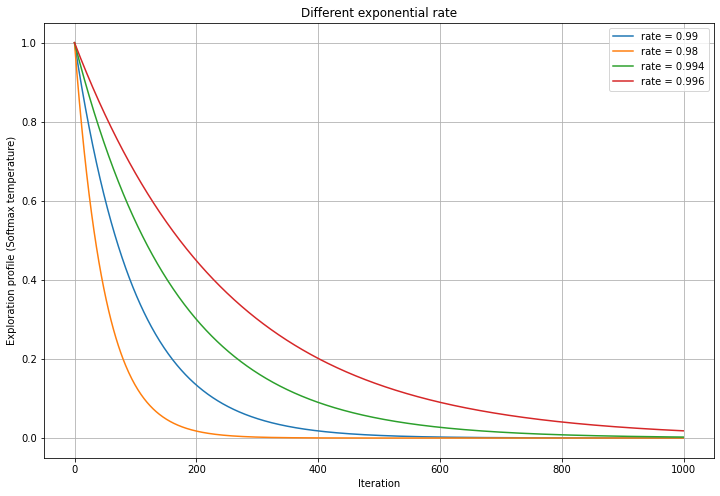

In [ ]:
# Different exponential rate
ep = exploration_profile(1000, 1, rate=0.99)
ep1 = exploration_profile(1000, 1, rate=0.994)
ep2 = exploration_profile(1000, 1, rate=0.996)
ep3 = exploration_profile(1000, 1, rate=0.98)

plt.figure(figsize=(12,8))
plt.plot(ep, label = 'rate = 0.99')
plt.plot(ep3, label = 'rate = 0.98')
plt.plot(ep1, label = 'rate = 0.994')
plt.plot(ep2, label = 'rate = 0.996')
plt.grid()
plt.title('Different exponential rate')
plt.xlabel('Iteration')
plt.ylabel('Exploration profile')
plt.legend()
plt.show()

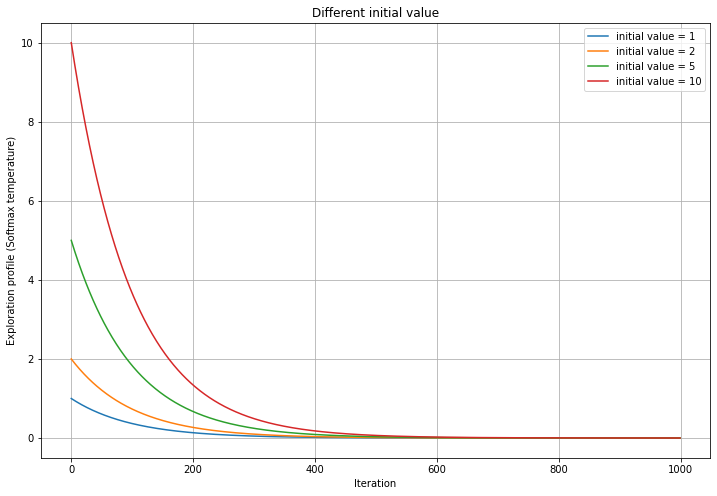

In [ ]:
# Different initial value
ep = exploration_profile(1000, 1, rate=0.99)
ep1 = exploration_profile(1000, 2, rate=0.99)
ep2 = exploration_profile(1000, 5, rate=0.99)
ep3 = exploration_profile(1000, 10, rate=0.99)

plt.figure(figsize=(12,8))
plt.plot(ep, label = 'initial value = 1')
plt.plot(ep1, label = 'initial value = 2')
plt.plot(ep2, label = 'initial value = 5')
plt.plot(ep3, label = 'initial value = 10')
plt.grid()
plt.title('Different initial value')
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')
plt.legend()
plt.show()

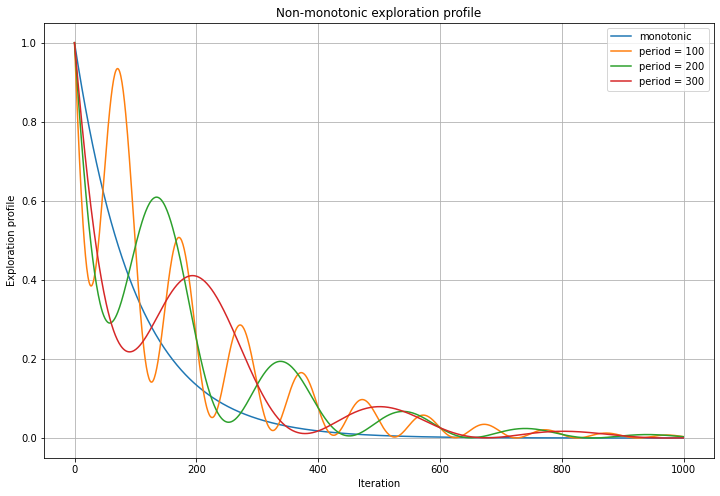

In [ ]:
# Non-monotonic exploration profile
ep = exploration_profile(1000, 1, rate=0.99, period=0, rate2=0.994)
ep1 = exploration_profile(1000, 1, rate=0.99, period=100, rate2=0.995)
ep2 = exploration_profile(1000, 1, rate=0.99, period=200, rate2=0.995)
ep3 = exploration_profile(1000, 1, rate=0.99, period=300, rate2=0.995)

plt.figure(figsize=(12,8))
plt.plot(ep, label = 'monotonic')
plt.plot(ep1, label = 'period = 100')
plt.plot(ep2, label = 'period = 200')
plt.plot(ep3, label = 'period = 300')
plt.grid()
plt.title('Non-monotonic exploration profile')
plt.xlabel('Iteration')
plt.ylabel('Exploration profile')
plt.legend()
plt.show()

# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

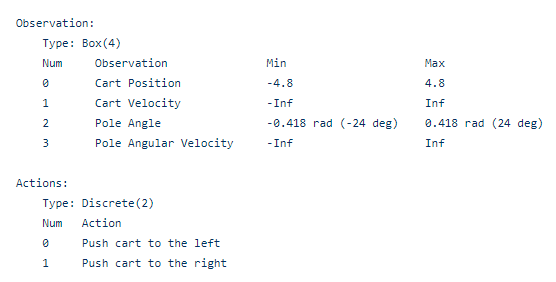

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the s### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")tate space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


# Full frames

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        # self.unflatten = nn.Unflatten(dim=0, unflattened_size=(-1, 400, 600, 3))
        self.flatten = nn.Flatten(start_dim=1)

        self.conv = nn.Sequential(
                      nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2)),

                      nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2)),

                      nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2))
                )
        
        self.linear = nn.Sequential(
                nn.Linear(640, 64),
                nn.Tanh(),
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, action_space_dim)
                )

    def forward(self, x):
        # print(x.shape)
        # x = self.unflatten(x)
        x = x.reshape(-1, 400, 600, 3)
        x = x.permute(0, 3, 1, 2)
        # print(x.shape)
        x = self.conv(x)
        # print(x.shape)

        # x = self.unflatten(x)
        x = self.flatten(x)
        # print(x.shape)
        return self.linear(x)

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)[0] # !!!!!!!!!!!!!!!!!!!!!!!!!!!!

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) 
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # We need to distinguish between final and non-final states!
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) 
    # NB: we have previously set the next state to None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # future rewards will be zero for final states

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma) # these are our labels
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # we are optimizing the best possible thing that we can do given our current knowledge, 
    # agaist the direct output of the network (the current policy)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2) # if the sum of the gradinets is larger than 2, we rescale them
    # This prevents the weigths to update too fast
    optimizer.step()

In [ ]:
state_space_dim = 400*600*3

In [ ]:
min_samples_for_training = 150 # Minimum samples in the replay memory to enable the training
# batch_size = 128 # Number of samples to take from the replay memory for each update
batch_size = 50 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(0)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN(720000, action_space_dim)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN(720000, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    test_score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # Reset the environment and get the initial state
        _ = env.reset()
        state = env.render(mode='rgb_array')
        state = state.flatten()/255
        # state = state/255
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            _, reward, done, info = env.step(action)
            next_state = env.render(mode='rgb_array')
            next_state = next_state.flatten()/255
            # next_state = next_state/255

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > min_samples_for_training: 
                print('Updating policy network')
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            state = next_state
        
        # Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Test the current network for 5 episodes with temperature = 0
        if (episode_num + 1) % 10 == 0:
            # print('Test (temperature = 0)...')
            score_log = []
            # Let's try for a total of 5 episodes
            for num_episode in range(5): 
                # Reset the environment and get the initial state
                _ = env.reset()
                state = env.render(mode='rgb_array')
                state = state.flatten()/255
                # state = state/255
                # Reset the score. The final score will be the total amount of steps before the pole falls
                score = 0
                done = False
                # Go on until the pole falls off or the score reach 490
                while not done:
                    # Choose the best action (temperature 0)
                    action, q_values = choose_action_softmax(policy_net, state, temperature=0)
                    # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                    next_state, reward, done, info = env.step(action)
                    # Visually render the environment
                    next_state = env.render(mode='rgb_array')
                    next_state = next_state.flatten()/255
                    # next_state = next_state/255
                    # Here it makes no sense to change the reward
                    # Update the final score (+1 for each step)
                    score += 1 # or +=1
                    # Set the current state for the next iteration
                    state = next_state
                    # Check if the episode ended (the pole fell down)
                # Print the final score
                print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
                score_log.append(score)
            avg_score = np.mean(score_log)
            # print(f'Average test score (over 5 runs) after {episode_num + 1} training episodes: {avg_score:.1f}')
            test_score_log.append(avg_score)
            # Early stopping
            if avg_score == 500:
                print(f'Game solved after {episode_num + 1} training episodes')
                break

            if episode_num == iter-1 and avg_score < 500:
                print(f'Game NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    env.close()
    # return test_score_log, episode_num+1
    return test_score_log, episode_num+1, policy_net # if we want to further test, we need also the policy_net

In [ ]:
score_log, ep_num, policy_net = main(iter=50, gamma=0.97, replay_memory_capacity=200, lr=0.1, target_net_update_steps=5, 
                                   bad_state_penalty=0, penalization='both', exp_policy='softmax', 
                                   initial_value=1, rate=0.994, period=0)

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.976215137296
Updating target network...
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.970357846472224
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.9645356993933907
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updating policy network
Updati

KeyboardInterrupt: ignored

# Full frames GPU

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        # self.unflatten = nn.Unflatten(dim=0, unflattened_size=(-1, 400, 600, 3))
        self.flatten = nn.Flatten(start_dim=1)

        self.conv = nn.Sequential(
                      nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2)),

                      nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2)),

                      nn.Conv2d(32, 16, kernel_size=3, stride=2, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2))
                )
        
        self.linear = nn.Sequential(
                nn.Linear(640, 64),
                nn.Tanh(),
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, action_space_dim)
                )

    def forward(self, x):
        # print(x.shape)
        # x = self.unflatten(x)
        x = x.reshape(-1, 400, 600, 3)
        x = x.permute(0, 3, 1, 2)
        # print(x.shape)
        x = self.conv(x)
        # print(x.shape)

        # x = self.unflatten(x)
        x = self.flatten(x)
        # print(x.shape)
        return self.linear(x)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon, device):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device) # Convert the state to tensor
        net_out = net(state).cpu()

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
def choose_action_softmax(net, state, temperature, device):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device)
        net_out = net(state)[0].cpu() # !!!!!!!!!!!!!!!!!!!!!!!!!!!!

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) 
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32).to(device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64).to(device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32).to(device)

    # We need to distinguish between final and non-final states!
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32).to(device)
    # NB: we have previously set the next state to None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool).to(device)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    q_values = q_values#.cpu()
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
        q_values_target = q_values_target#.cpu()
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # future rewards will be zero for final states

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma) # these are our labels
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # we are optimizing the best possible thing that we can do given our current knowledge, 
    # agaist the direct output of the network (the current policy)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2) # if the sum of the gradinets is larger than 2, we rescale them
    # This prevents the weigths to update too fast
    optimizer.step()

In [ ]:
state_space_dim = 400*600*3

In [ ]:
min_samples_for_training = 150 # Minimum samples in the replay memory to enable the training
# batch_size = 128 # Number of samples to take from the replay memory for each update
batch_size = 50 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0, device=device):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(1)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN(720000, action_space_dim).to(device)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN(720000, action_space_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    test_score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # Reset the environment and get the initial state
        _ = env.reset()
        state = env.render(mode='rgb_array')
        state = state.flatten()/255
        # state = state/255
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau, device = device)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau, device = device)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            _, reward, done, info = env.step(action)
            next_state = env.render(mode='rgb_array')
            next_state = next_state.flatten()/255
            # next_state = next_state/255

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > min_samples_for_training: 
                print('Updating policy network')
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device = device)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            state = next_state
        
        # Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Test the current network for 5 episodes with temperature = 0
        if (episode_num + 1) % 10 == 0:
            # print('Test (temperature = 0)...')
            score_log = []
            # Let's try for a total of 5 episodes
            for num_episode in range(5): 
                # Reset the environment and get the initial state
                _ = env.reset()
                state = env.render(mode='rgb_array')
                state = state.flatten()/255
                # state = state/255
                # Reset the score. The final score will be the total amount of steps before the pole falls
                score = 0
                done = False
                # Go on until the pole falls off or the score reach 490
                while not done:
                    # Choose the best action (temperature 0)
                    action, q_values = choose_action_softmax(policy_net, state, temperature=0)
                    # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                    next_state, reward, done, info = env.step(action)
                    # Visually render the environment
                    next_state = env.render(mode='rgb_array')
                    next_state = next_state.flatten()/255
                    # next_state = next_state/255
                    # Here it makes no sense to change the reward
                    # Update the final score (+1 for each step)
                    score += 1 # or +=1
                    # Set the current state for the next iteration
                    state = next_state
                    # Check if the episode ended (the pole fell down)
                # Print the final score
                print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
                score_log.append(score)
            avg_score = np.mean(score_log)
            # print(f'Average test score (over 5 runs) after {episode_num + 1} training episodes: {avg_score:.1f}')
            test_score_log.append(avg_score)
            # Early stopping
            if avg_score == 500:
                print(f'Game solved after {episode_num + 1} training episodes')
                break

            if episode_num == iter-1 and avg_score < 500:
                print(f'Game NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    env.close()
    # return test_score_log, episode_num+1
    return test_score_log, episode_num+1, policy_net # if we want to further test, we need also the policy_net

In [ ]:
score_log, ep_num, policy_net = main(iter=50, gamma=0.97, replay_memory_capacity=200, lr=0.1, target_net_update_steps=5, 
                                   bad_state_penalty=0, penalization='both', exp_policy='softmax', 
                                   initial_value=1, rate=0.994, period=0, device=device)

# Cut frames

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        # self.unflatten = nn.Unflatten(dim=0, unflattened_size=(-1, 400, 600, 3))
        self.flatten = nn.Flatten(start_dim=1)

        self.conv = nn.Sequential(
                      nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2)),

                      nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2)),
                )
        
        self.linear = nn.Sequential(
                nn.Linear(24, 64),
                nn.Tanh(),
                nn.Linear(64, action_space_dim)
                )

    def forward(self, x):
        # print(x.shape)
        # x = self.unflatten(x)
        x = x.reshape(-1, 24, 40, 1)
        x = x.permute(0, 3, 1, 2)
        # print(x.shape)
        x = self.conv(x)
        # print(x.shape)

        # x = self.unflatten(x)
        x = self.flatten(x)
        # print(x.shape)
        return self.linear(x)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon, device):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device) # Convert the state to tensor
        net_out = net(state).cpu()

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
def choose_action_softmax(net, state, temperature, device):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device)
        net_out = net(state)[0].cpu()

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) 
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32).to(device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64).to(device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32).to(device)

    # We need to distinguish between final and non-final states!
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32).to(device)
    # NB: we have previously set the next state to None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool).to(device)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # future rewards will be zero for final states

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma) # these are our labels
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # we are optimizing the best possible thing that we can do given our current knowledge, 
    # agaist the direct output of the network (the current policy)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2) # if the sum of the gradinets is larger than 2, we rescale them
    # This prevents the weigths to update too fast
    optimizer.step()

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0)
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
a = env.reset()
frames = []
im_frame = env.render(mode='rgb_array')
frames.append(im_frame)
for i in range(1):
    next_state, reward, done, info = env.step(1)
    im_frame = env.render(mode='rgb_array')
    frames.append(im_frame)
env.close()

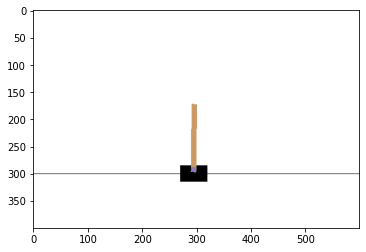

In [ ]:
plt.imshow(im_frame)

In [ ]:
cut = im_frame[np.arange(170,290,5), :, 2][:, np.arange(200,400,5)]/255 #.flatten()/255

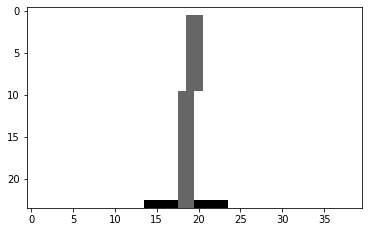

In [ ]:
plt.imshow(cut, cmap='gray')

In [ ]:
new = cut == 1

In [ ]:
new.shape

(24, 40)

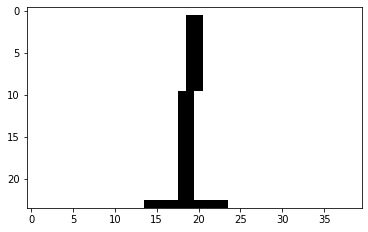

In [ ]:
plt.imshow(new, cmap='gray')

In [ ]:
all = im_frame[np.arange(170,290,5), :, 2][:, np.arange(200,400,5)]/255 ==1

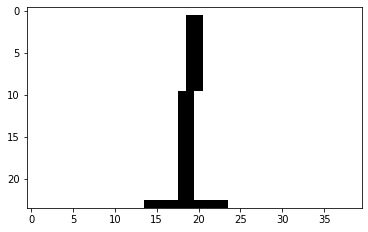

In [ ]:
plt.imshow(all, cmap='gray')

In [ ]:
net = DQN(state_space_dim, action_space_dim)
state = torch.tensor(all, dtype=torch.float32).flatten()
net_out = net(state)

In [ ]:
# final transformation:
[np.arange(170,290,5), :, 2][:, np.arange(200,400,5)].flatten()/255 ==1

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
min_samples_for_training = 500 # Minimum samples in the replay memory to enable the training
# batch_size = 128 # Number of samples to take from the replay memory for each update
batch_size = 50 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0, device = device):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(1)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN(720000, action_space_dim).to(device)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN(720000, action_space_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # Reset the environment and get the initial state
        _ = env.reset()
        state = env.render(mode='rgb_array')
        # state = state.flatten()/255
        state = state[np.arange(170,290,5), :, 2][:, np.arange(200,400,5)].flatten()/255 ==1
        
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        # score_log = []

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau, device = device)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau, device = device)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            envstate, reward, done, info = env.step(action)
            reward = reward - 5 * np.abs(envstate[0]) - 10 * np.abs(envstate[2]) 
            next_state = env.render(mode='rgb_array')
            next_state = next_state[np.arange(170,290,5), :, 2][:, np.arange(200,400,5)].flatten()/255 ==1
            # next_state = next_state/255

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > min_samples_for_training: 
                # print('Updating policy network')
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device = device)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            state = next_state
        
        score_log.append(score)

        # Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            # print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

   
    max_score = np.max(score_log)
    print(f'Max score: {max_score}')

            # # Early stopping
            # if avg_score == 500:
            #     print(f'\nGame solved after {episode_num + 1} training episodes')
            #     break

            # if episode_num == iter-1 and avg_score < 500:
            #     print(f'\nGame NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    env.close()
    # return test_score_log, episode_num+1
    return score_log, episode_num+1, policy_net # if we want to further test, we need also the policy_net

In [ ]:
results = []
pbar = tqdm(total = 16, desc = 'Optimization')
for rate in [0.99, 0.994]:
  for initial_value in [1, 5]:
    # for period in [0, 100]:
      for tnus in [1, 10]: # target_net_update_steps
        for lr in [1e-2, 1e-3]: # 1e-2

          print(f'rate: {rate}, initial_value: {initial_value}, target_net_update_steps: {tnus}, lr: {lr}')
          # key = f'rate:{rate}, init_v:{initial_value}, period: {period}, tnup: {tnus}, lr: {lr}'
          key = f'b:{rate}, t0:{initial_value}, ts:{tnus}, lr:{lr}'

          score_log, ep_num, _ = main(iter=1000, gamma=0.97, replay_memory_capacity=2000, lr=lr, target_net_update_steps=tnus, 
                                   bad_state_penalty=0, penalization='both', exp_policy='softmax', 
                                   initial_value=initial_value, rate=rate, period=0)
          results.append((key, ep_num, score_log))
          print()
          pbar.update(1)

rate: 0.99, initial_value: 1, target_net_update_steps: 1, lr: 0.01


EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.99
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.9801
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.970299
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.96059601
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.9509900498999999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.941480149401
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 0.9320653479069899
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 0.9227446944279201
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 0.9135172474836408
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 0.9043820750088044
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 0.8953382542587164
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 0.8863848717161292
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 0.8775210229989678
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 0.8687458127689782
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 0.8600583546412884
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 0.8

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.99
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.9801
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.970299
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.96059601
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.9509900498999999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.941480149401
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 0.9320653479069899
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 0.9227446944279201
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 0.9135172474836408
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 0.9043820750088044
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 0.8953382542587164
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 0.8863848717161292
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 0.8775210229989678
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 0.8687458127689782
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 0.8600583546412884
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 0.8

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.99
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.9801
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.970299
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.96059601
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.9509900498999999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.941480149401
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 0.9320653479069899
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 0.9227446944279201
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 0.9135172474836408
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 0.9043820750088044
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 0.8953382542587164
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 0.8863848717161292
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 0.8775210229989678
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 0.8687458127689782
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 0.8600583546412884
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 0.8

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.99
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.9801
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.970299
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.96059601
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.9509900498999999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.941480149401
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 0.9320653479069899
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 0.9227446944279201
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 0.9135172474836408
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 0.9043820750088044
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 0.8953382542587164
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 0.8863848717161292
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 0.8775210229989678
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 0.8687458127689782
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 0.8600583546412884
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 0.8

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.95
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.9005
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.851495
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.8029800499999995
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 4.754950249499999
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 4.707400747005
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 4.660326739534949
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.6137234721396005
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.567586237418205
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.521910375044022
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.476691271293582
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.4319243585806465
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.387605114994839
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.343729063844891
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.3002917732064425
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.95
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.9005
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.851495
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.8029800499999995
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 4.754950249499999
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 4.707400747005
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 4.660326739534949
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.6137234721396005
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.567586237418205
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.521910375044022
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.476691271293582
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.4319243585806465
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.387605114994839
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.343729063844891
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.3002917732064425
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.95
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.9005
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.851495
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.8029800499999995
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 4.754950249499999
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 4.707400747005
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 4.660326739534949
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.6137234721396005
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.567586237418205
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.521910375044022
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.476691271293582
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.4319243585806465
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.387605114994839
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.343729063844891
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.3002917732064425
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.95
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.9005
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.851495
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.8029800499999995
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 4.754950249499999
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 4.707400747005
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 4.660326739534949
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.6137234721396005
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.567586237418205
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.521910375044022
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.476691271293582
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.4319243585806465
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.387605114994839
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.343729063844891
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.3002917732064425
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 17 - Temp

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 17 - Temp

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 17 - Temp

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 17 - Temp

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.97
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.94018
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.91053892
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.88107568648
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 4.85178923236112
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 4.822678496966954
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 4.793742425985151
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.7649799714292405
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.736390091600665
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.707971751051061
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.679723920544754
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.651645577021486
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.6237357035593565
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.595993289338001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.568417329601973
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.5

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.97
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.94018
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.91053892
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.88107568648
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 4.85178923236112
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 4.822678496966954
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 4.793742425985151
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.7649799714292405
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.736390091600665
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.707971751051061
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.679723920544754
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.651645577021486
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.6237357035593565
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.595993289338001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.568417329601973
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.5

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.97
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.94018
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.91053892
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.88107568648
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 4.85178923236112
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 4.822678496966954
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 4.793742425985151
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.7649799714292405
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.736390091600665
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.707971751051061
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.679723920544754
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.651645577021486
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.6237357035593565
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.595993289338001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.568417329601973
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.5

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.97
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.94018
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.91053892
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.88107568648
EPISODE: 6 - FINAL SCORE: 14 - Temperature: 4.85178923236112
EPISODE: 7 - FINAL SCORE: 34 - Temperature: 4.822678496966954
EPISODE: 8 - FINAL SCORE: 27 - Temperature: 4.793742425985151
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.7649799714292405
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.736390091600665
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.707971751051061
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.679723920544754
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.651645577021486
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.6237357035593565
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.595993289338001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.568417329601973
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.5

Best score: 114

# Cut frames (wider cut)

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        # self.unflatten = nn.Unflatten(dim=0, unflattened_size=(-1, 400, 600, 3))
        self.flatten = nn.Flatten(start_dim=1)

        self.conv = nn.Sequential(
                      nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2)),

                      nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2)),
                )
        
        self.linear = nn.Sequential(
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, 128),
                nn.Tanh(),
                nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        # print(x.shape)
        # x = self.unflatten(x)
        x = x.reshape(-1, 29, 80, 1)
        x = x.permute(0, 3, 1, 2)
        # print(x.shape)
        x = self.conv(x)
        # print(x.shape)

        # x = self.unflatten(x)
        x = self.flatten(x)
        # print(x.shape)
        return self.linear(x)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon, device):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device) # Convert the state to tensor
        net_out = net(state).cpu()

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
def choose_action_softmax(net, state, temperature, device):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device)
        net_out = net(state)[0].cpu()

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) 
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32).to(device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64).to(device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32).to(device)

    # We need to distinguish between final and non-final states!
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32).to(device)
    # NB: we have previously set the next state to None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool).to(device)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # future rewards will be zero for final states

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma) # these are our labels
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # we are optimizing the best possible thing that we can do given our current knowledge, 
    # agaist the direct output of the network (the current policy)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2) # if the sum of the gradinets is larger than 2, we rescale them
    # This prevents the weigths to update too fast
    optimizer.step()

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0)
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
a = env.reset()
frames = []
im_frame = env.render(mode='rgb_array')
frames.append(im_frame)
for i in range(1):
    next_state, reward, done, info = env.step(1)
    im_frame = env.render(mode='rgb_array')
    frames.append(im_frame)
env.close()

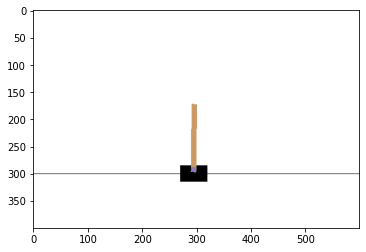

In [ ]:
plt.imshow(im_frame)

In [ ]:
cut = im_frame[np.arange(175,290,4), :, 2][:, np.arange(100,500,5)]/255 #.flatten()/255

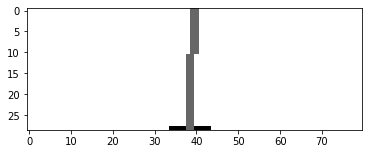

In [ ]:
plt.imshow(cut, cmap='gray')

In [ ]:
new = cut == 1

In [ ]:
new.shape

(29, 80)

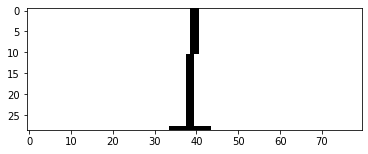

In [ ]:
plt.imshow(new, cmap='gray')

In [ ]:
all = im_frame[np.arange(175,290,4), :, 2][:, np.arange(100,500,5)]/255 ==1

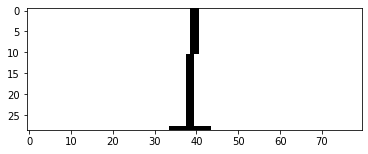

In [ ]:
plt.imshow(all, cmap='gray')

In [ ]:
net = DQN(state_space_dim, action_space_dim)
state = torch.tensor(new, dtype=torch.float32).flatten()
net_out = net(state)

In [ ]:
# final transformation:
[np.arange(175,290,4), :, 2][:, np.arange(100,500,5)].flatten()/255 ==1

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
min_samples_for_training = 500 # Minimum samples in the replay memory to enable the training
# batch_size = 128 # Number of samples to take from the replay memory for each update
batch_size = 50 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0, device = device):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(1)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN(720000, action_space_dim).to(device)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN(720000, action_space_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # Reset the environment and get the initial state
        _ = env.reset()
        state = env.render(mode='rgb_array')
        # state = state.flatten()/255
        state = state[np.arange(175,290,4), :, 2][:, np.arange(100,500,5)].flatten()/255 ==1
        
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        # score_log = []

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau, device = device)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau, device = device)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            envstate, reward, done, info = env.step(action)
            reward = reward - 5 * np.abs(envstate[0]) - 10 * np.abs(envstate[2]) 
            next_state = env.render(mode='rgb_array')
            next_state = next_state[np.arange(175,290,4), :, 2][:, np.arange(100,500,5)].flatten()/255 ==1
            # next_state = next_state/255

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > min_samples_for_training: 
                # print('Updating policy network')
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device = device)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            state = next_state
        
        score_log.append(score)

        # Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            # print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        
    max_score = np.max(score_log)
    print(f'Max score: {max_score}')

    env.close()
    # return test_score_log, episode_num+1
    return score_log, max_score, episode_num+1, policy_net # if we want to further test, we need also the policy_net

In [ ]:
results = []
max_scores = []
pbar = tqdm(total = 16, desc = 'Optimization')
for rate in [0.99, 0.994]:
  for initial_value in [1, 5]:
    # for period in [0, 100]:
      for tnus in [1, 10]: # target_net_update_steps
        for lr in [1e-2, 1e-3]: # 1e-2

          print(f'rate: {rate}, initial_value: {initial_value}, target_net_update_steps: {tnus}, lr: {lr}')
          # key = f'rate:{rate}, init_v:{initial_value}, period: {period}, tnup: {tnus}, lr: {lr}'
          key = f'b:{rate}, t0:{initial_value}, ts:{tnus}, lr:{lr}'

          score_log, ep_num, max_score, _ = main(iter=1000, gamma=0.97, replay_memory_capacity=2000, lr=lr, target_net_update_steps=tnus, 
                                   bad_state_penalty=0, penalization='both', exp_policy='softmax', 
                                   initial_value=initial_value, rate=rate, period=0)
          results.append((key, ep_num, score_log))
          max_scores.append((key,max_score))
          print()
          pbar.update(1)
print(max_scores)

rate: 0.99, initial_value: 1, target_net_update_steps: 1, lr: 0.01


EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.99
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.9801
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.970299
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.96059601
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.9509900498999999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.941480149401
EPISODE: 8 - FINAL SCORE: 47 - Temperature: 0.9320653479069899
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 0.9227446944279201
EPISODE: 10 - FINAL SCORE: 24 - Temperature: 0.9135172474836408
EPISODE: 11 - FINAL SCORE: 41 - Temperature: 0.9043820750088044
EPISODE: 12 - FINAL SCORE: 12 - Temperature: 0.8953382542587164
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 0.8863848717161292
EPISODE: 14 - FINAL SCORE: 14 - Temperature: 0.8775210229989678
EPISODE: 15 - FINAL SCORE: 21 - Temperature: 0.8687458127689782
EPISODE: 16 - FINAL SCORE: 21 - Temperature: 0.8600583546412884
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 0.8

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.99
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.9801
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.970299
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.96059601
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.9509900498999999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.941480149401
EPISODE: 8 - FINAL SCORE: 47 - Temperature: 0.9320653479069899
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 0.9227446944279201
EPISODE: 10 - FINAL SCORE: 24 - Temperature: 0.9135172474836408
EPISODE: 11 - FINAL SCORE: 41 - Temperature: 0.9043820750088044
EPISODE: 12 - FINAL SCORE: 12 - Temperature: 0.8953382542587164
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 0.8863848717161292
EPISODE: 14 - FINAL SCORE: 14 - Temperature: 0.8775210229989678
EPISODE: 15 - FINAL SCORE: 21 - Temperature: 0.8687458127689782
EPISODE: 16 - FINAL SCORE: 21 - Temperature: 0.8600583546412884
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 0.8

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.99
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.9801
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.970299
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.96059601
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.9509900498999999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.941480149401
EPISODE: 8 - FINAL SCORE: 47 - Temperature: 0.9320653479069899
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 0.9227446944279201
EPISODE: 10 - FINAL SCORE: 24 - Temperature: 0.9135172474836408
EPISODE: 11 - FINAL SCORE: 41 - Temperature: 0.9043820750088044
EPISODE: 12 - FINAL SCORE: 12 - Temperature: 0.8953382542587164
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 0.8863848717161292
EPISODE: 14 - FINAL SCORE: 14 - Temperature: 0.8775210229989678
EPISODE: 15 - FINAL SCORE: 21 - Temperature: 0.8687458127689782
EPISODE: 16 - FINAL SCORE: 21 - Temperature: 0.8600583546412884
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 0.8

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.99
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.9801
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.970299
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.96059601
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.9509900498999999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.941480149401
EPISODE: 8 - FINAL SCORE: 47 - Temperature: 0.9320653479069899
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 0.9227446944279201
EPISODE: 10 - FINAL SCORE: 24 - Temperature: 0.9135172474836408
EPISODE: 11 - FINAL SCORE: 41 - Temperature: 0.9043820750088044
EPISODE: 12 - FINAL SCORE: 12 - Temperature: 0.8953382542587164
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 0.8863848717161292
EPISODE: 14 - FINAL SCORE: 14 - Temperature: 0.8775210229989678
EPISODE: 15 - FINAL SCORE: 21 - Temperature: 0.8687458127689782
EPISODE: 16 - FINAL SCORE: 21 - Temperature: 0.8600583546412884
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 0.8

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.95
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.9005
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.851495
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.8029800499999995
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.754950249499999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.707400747005
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.660326739534949
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.6137234721396005
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.567586237418205
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.521910375044022
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.476691271293582
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.4319243585806465
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.387605114994839
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.343729063844891
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.3002917732064425
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.95
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.9005
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.851495
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.8029800499999995
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.754950249499999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.707400747005
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.660326739534949
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.6137234721396005
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.567586237418205
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.521910375044022
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.476691271293582
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.4319243585806465
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.387605114994839
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.343729063844891
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.3002917732064425
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.95
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.9005
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.851495
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.8029800499999995
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.754950249499999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.707400747005
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.660326739534949
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.6137234721396005
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.567586237418205
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.521910375044022
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.476691271293582
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.4319243585806465
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.387605114994839
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.343729063844891
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.3002917732064425
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.95
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.9005
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.851495
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.8029800499999995
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.754950249499999
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.707400747005
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.660326739534949
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.6137234721396005
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.567586237418205
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.521910375044022
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.476691271293582
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.4319243585806465
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.387605114994839
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.343729063844891
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.3002917732064425
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 47 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 24 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 41 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 12 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 14 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 21 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 21 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 17 - Temp

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 47 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 24 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 41 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 12 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 14 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 21 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 21 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 17 - Temp

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 47 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 24 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 41 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 12 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 14 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 21 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 21 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 17 - Temp

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 47 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 17 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 24 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 41 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 12 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 19 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 14 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 21 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 21 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 17 - Temp

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.97
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.94018
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.91053892
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.88107568648
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.85178923236112
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.822678496966954
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.793742425985151
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.7649799714292405
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.736390091600665
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.707971751051061
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.679723920544754
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.651645577021486
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.6237357035593565
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.595993289338001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.568417329601973
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.5

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.97
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.94018
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.91053892
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.88107568648
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.85178923236112
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.822678496966954
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.793742425985151
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.7649799714292405
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.736390091600665
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.707971751051061
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.679723920544754
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.651645577021486
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.6237357035593565
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.595993289338001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.568417329601973
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.5

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.97
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.94018
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.91053892
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.88107568648
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.85178923236112
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.822678496966954
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.793742425985151
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.7649799714292405
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.736390091600665
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.707971751051061
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.679723920544754
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.651645577021486
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.6237357035593565
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.595993289338001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.568417329601973
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.5

EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.97
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.94018
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.91053892
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.88107568648
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.85178923236112
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.822678496966954
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.793742425985151
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.7649799714292405
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.736390091600665
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.707971751051061
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.679723920544754
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.651645577021486
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.6237357035593565
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.595993289338001
EPISODE: 16 - FINAL SCORE: 14 - Temperature: 4.568417329601973
EPISODE: 17 - FINAL SCORE: 17 - Temperature: 4.5

Best score: 108

# Cut frames + past 3 frames

In [ ]:
class ReplayMemoryMod(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"
        # Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end

    def push(self, state, action, next_state, reward):
        # Add the tuple (state, action, next_state, reward) to the queue
        self.memory.append( (state, action, next_state, reward) ) 

    def push(self, queue):
        self.memory.append( (queue) ) 

    def sample(self, batch_size):
        # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        batch_size = min(batch_size, len(self)) 
        # Randomly select "batch_size" samples
        return random.sample(self.memory, batch_size) 

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [ ]:
_ = env.reset()
state = env.render(mode='rgb_array')
# state = state[np.arange(175,290,4), :, 2][:, np.arange(100,500,5)]/255 ==1
# state.shape
state = state[np.arange(175,290,4), :, 2][:, np.arange(100,500,5)].flatten()/255 ==1
state = torch.tensor(state, dtype=torch.float32).to(device)
state1 = state; state2 = state; state3 = state

In [ ]:
class DQN(nn.Module):

    def __init__(self):
        super().__init__()

        # self.unflatten = nn.Unflatten(dim=0, unflattened_size=(-1, 400, 600, 3))
        self.flatten = nn.Flatten(start_dim=1)

        self.conv = nn.Sequential(
                      nn.Conv2d(4, 16, kernel_size=3, stride=2, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2)),

                      nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=0),
                      nn.Tanh(),
                      nn.AvgPool2d(kernel_size=(2,2)),
                )
        
        self.linear = nn.Sequential(
                nn.Linear(128, 256),
                nn.Tanh(),
                nn.Linear(256, 64),
                nn.Tanh(),
                nn.Linear(64, action_space_dim)
                )

    def forward(self, x, x1, x2, x3):
        # print(x.shape)
        # x = self.unflatten(x)
        x = x.reshape(-1, 29, 80, 1).permute(0, 3, 1, 2)
        x1 = x1.reshape(-1, 29, 80, 1).permute(0, 3, 1, 2)
        x2 = x2.reshape(-1, 29, 80, 1).permute(0, 3, 1, 2)
        x3 = x3.reshape(-1, 29, 80, 1).permute(0, 3, 1, 2)
        # print(x.shape)
        x = torch.cat((x, x1, x2, x3), 1)
        # print(x.shape)

        x = self.conv(x)
        # print(x.shape)

        # x = self.unflatten(x)
        x = self.flatten(x)
        # print(x.shape)
        return self.linear(x)

In [ ]:
def choose_action_epsilon_greedy(net, state, state1, state2, state3, temperature, device):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        # state = torch.tensor(state, dtype=torch.float32).to(device) # Convert the state to tensor
        net_out = net(state, state1, state2, state3).cpu()

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
min_samples_for_training = 500 # Minimum samples in the replay memory to enable the training
# batch_size = 128 # Number of samples to take from the replay memory for each update
batch_size = 50 # Number of samples to take from the replay memory for each update
foresee = 7

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0, device = device):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(1)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemoryMod(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN().to(device)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # Reset the environment and get the initial state
        _ = env.reset()
        state = env.render(mode='rgb_array')
        state = state[np.arange(175,290,4), :, 2][:, np.arange(100,500,5)].flatten()/255 ==1
        state = torch.tensor(state, dtype=torch.float32).to(device)
        state1 = state; state2 = state; state3 = state
        
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Store past episodes
        queue = deque(maxlen=foresee)

        # Go on until the pole falls off
        while not done:

            state = env.render(mode='rgb_array')
            state = state[np.arange(175,290,4), :, 2][:, np.arange(100,500,5)].flatten()/255 ==1
            state = torch.tensor(state, dtype=torch.float32).to(device)

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            action, q_values = choose_action_epsilon_greedy(policy_net, state, state1, state2, state3, temperature=tau, device = device)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            envstate, reward, done, info = env.step(action)
            reward = (torch.tensor(reward - 5 * np.abs(envstate[0]) - 10 * np.abs(envstate[2])))
            # reward=(torch.tensor(reward)+pos_weight*torch.abs(torch.tensor(state[0]))+angle_weight*(0.418-torch.abs(torch.tensor(state[2])))**2)
            # next_state = env.render(mode='rgb_array')
            # next_state = next_state[np.arange(175,290,4), :, 2][:, np.arange(100,500,5)].flatten()/255 ==1
            # next_state = next_state/255

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= 10
                # next_state = None
            
            queue.append([state, action, reward])

            if score >= foresee:  
                # Update the replay memory
                replay_mem.push(list(queue))
            
            # # Update the replay memory
            # replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > min_samples_for_training: 
                # print('Updating policy network')
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device = device)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Update states
            state1 = state; state2 = state1; state3 = state2

        queue.append([None, action, reward])
        if score > 5:
            replay_mem.push(list(queue))
        queue = None
        
        score_log.append(score)

        # Print the final score
        # print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            # print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

      
    max_score = np.max(score_log)
    print(f'Max score: {max_score}')

            # # Early stopping
            # if avg_score == 500:
            #     print(f'\nGame solved after {episode_num + 1} training episodes')
            #     break

            # if episode_num == iter-1 and avg_score < 500:
            #     print(f'\nGame NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    env.close()
    # return test_score_log, episode_num+1
    return score_log, max_score, episode_num+1, policy_net # if we want to further test, we need also the policy_net

In [ ]:
results = []
max_scores = []
pbar = tqdm(total = 24, desc = 'Optimization')
for rate in [0.99, 0.994]:
  for initial_value in [1]:
    # for period in [0, 100]:
      for tnus in [1, 10]: # target_net_update_steps
        for lr in [1e-2, 1e-3, 1e-4]: # 1e-2

          print(f'rate: {rate}, initial_value: {initial_value}, target_net_update_steps: {tnus}, lr: {lr}')
          # key = f'rate:{rate}, init_v:{initial_value}, period: {period}, tnup: {tnus}, lr: {lr}'
          key = f'b:{rate}, t0:{initial_value}, ts:{tnus}, lr:{lr}'

          score_log, max_score, ep_num, _ = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=lr, target_net_update_steps=tnus, 
                                   bad_state_penalty=0, penalization='both', exp_policy='softmax', 
                                   initial_value=initial_value, rate=rate, period=0)
          results.append((key, ep_num, score_log))
          max_scores.append((key,max_score))
          print()
          pbar.update(1)
print(max_scores)

rate: 0.99, initial_value: 1, target_net_update_steps: 1, lr: 0.01



Max score: 82

rate: 0.99, initial_value: 1, target_net_update_steps: 1, lr: 0.001



Max score: 89

rate: 0.99, initial_value: 1, target_net_update_steps: 1, lr: 0.0001



Max score: 83

rate: 0.99, initial_value: 1, target_net_update_steps: 10, lr: 0.01



Max score: 108

rate: 0.99, initial_value: 1, target_net_update_steps: 10, lr: 0.001



Max score: 84

rate: 0.99, initial_value: 1, target_net_update_steps: 10, lr: 0.0001



Max score: 95

rate: 0.994, initial_value: 1, target_net_update_steps: 1, lr: 0.01



Max score: 82

rate: 0.994, initial_value: 1, target_net_update_steps: 1, lr: 0.001



Max score: 89

rate: 0.994, initial_value: 1, target_net_update_steps: 1, lr: 0.0001



Max score: 83

rate: 0.994, initial_value: 1, target_net_update_steps: 10, lr: 0.01



Max score: 108

rate: 0.994, initial_value: 1, target_net_update_steps: 10, lr: 0.001



Max score: 84

rate: 0.994, initial_value: 1, target_net_update_steps: 10, lr: 0.0001



Max score: 95

[('b:0.99, t0:1, ts:1, lr:0.01', 82), ('b:0.99, t0:1, ts:1, lr:0.001', 89), ('b:0.99, t0:1, ts:1, lr:0.0001', 83), ('b:0.99, t0:1, ts:10, lr:0.01', 108), ('b:0.99, t0:1, ts:10, lr:0.001', 84), ('b:0.99, t0:1, ts:10, lr:0.0001', 95), ('b:0.994, t0:1, ts:1, lr:0.01', 82), ('b:0.994, t0:1, ts:1, lr:0.001', 89), ('b:0.994, t0:1, ts:1, lr:0.0001', 83), ('b:0.994, t0:1, ts:10, lr:0.01', 108), ('b:0.994, t0:1, ts:10, lr:0.001', 84), ('b:0.994, t0:1, ts:10, lr:0.0001', 95)]


Best score: 114

# Difference with last frame


In [ ]:
class DQN(nn.Module):

    def __init__(self):
        super().__init__()

        # self.unflatten = nn.Unflatten(dim=0, unflattened_size=(-1, 400, 600, 3))
        self.flatten = nn.Flatten(start_dim=1)

        self.conv = nn.Sequential(
                      nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=0),
                      nn.LeakyReLU(),
                      nn.AvgPool2d(kernel_size=(2,2)),

                      nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=0),
                      nn.LeakyReLU(),
                    #   nn.AvgPool2d(kernel_size=(2,2)),
                      nn.BatchNorm2d(32),

                      nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=0),
                      nn.BatchNorm2d(16),
                      nn.LeakyReLU(),
                    #   nn.AvgPool2d(kernel_size=(2,2)),
                    #   nn.BatchNorm2d(32)
                )
        
        self.linear = nn.Sequential(
                nn.Linear(3696, 512),
                
                nn.LeakyReLU(),
                nn.Linear(512, 128),
                nn.LeakyReLU(),
                nn.Linear(128, 2)
                )

    def forward(self, x):
        # print(x.shape)
        # x = self.unflatten(x)
        x = x.reshape(-1, 120, 200, 1)
        x = x.permute(0, 3, 1, 2)
        # print(x.shape)
        x = self.conv(x)
        # print(x.shape)

        # x = self.unflatten(x)
        x = self.flatten(x)
        # print(x.shape)
        return self.linear(x)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon, device):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device) # Convert the state to tensor
        net_out = net(state).cpu()

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
def choose_action_softmax(net, state, temperature, device):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device)
        net_out = net(state)[0].cpu()

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) 
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32).to(device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64).to(device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32).to(device)

    # We need to distinguish between final and non-final states!
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32).to(device)
    # NB: we have previously set the next state to None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool).to(device)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # future rewards will be zero for final states

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma) # these are our labels
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # we are optimizing the best possible thing that we can do given our current knowledge, 
    # agaist the direct output of the network (the current policy)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2) # if the sum of the gradinets is larger than 2, we rescale them
    # This prevents the weigths to update too fast
    optimizer.step()

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0)
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
a = env.reset()
frames = []
im_frame = env.render(mode='rgb_array')
frames.append(im_frame)
for i in range(1):
    next_state, reward, done, info = env.step(1)
    im_frame = env.render(mode='rgb_array')
    frames.append(im_frame)
for i in range(5):
    next_state, reward, done, info = env.step(1)
    im_frame1 = env.render(mode='rgb_array')
    frames.append(im_frame)
env.close()

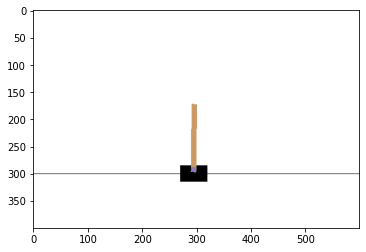

In [ ]:
plt.imshow(im_frame)

In [ ]:
cut = im_frame[np.arange(170,290,1), :, 2][:, np.arange(200,400,1)]/255# ==1

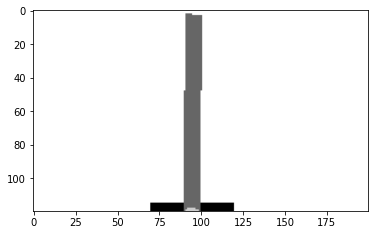

In [ ]:
plt.imshow(cut, cmap='gray')

In [ ]:
cut.shape

(120, 200)

In [ ]:
net = DQN()
state = torch.tensor(cut, dtype=torch.float32).flatten()
net_out = net(state)

torch.Size([1, 16, 11, 21])


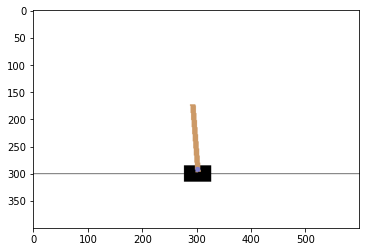

In [ ]:
plt.imshow(im_frame1)

In [ ]:
cut1 = im_frame1[np.arange(170,290,1), :, 2][:, np.arange(200,400,1)]/255 #==1

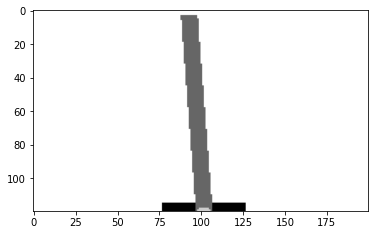

In [ ]:
plt.imshow(cut1, cmap='gray')

Difference

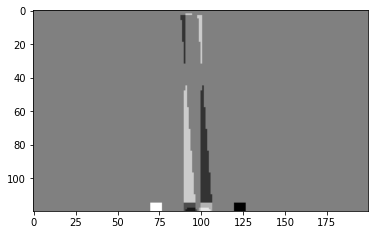

In [ ]:
sub = cut1-cut
plt.imshow(sub, cmap='gray')

In [ ]:
# final transformation:
[np.arange(170,290,1), :, 2][:, np.arange(200,400,1)].flatten()/255

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
min_samples_for_training = 500 # Minimum samples in the replay memory to enable the training
# batch_size = 128 # Number of samples to take from the replay memory for each update
batch_size = 50 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0, device = device):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(1)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN().to(device)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    # optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    optimizer= torch.optim.Adam(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # Reset the environment and get the initial state
        _ = env.reset()
        screen = env.render(mode='rgb_array')
        # state = state.flatten()/255
        screen = screen[np.arange(170,290,1), :, 2][:, np.arange(200,400,1)].flatten()/255
        next_screen = screen
        state = next_screen - screen
        
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        # score_log = []

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau, device = device)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau, device = device)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            envstate, reward, done, info = env.step(action)
            reward = reward - 50 * np.abs(envstate[0]) - 10 * np.abs(envstate[2]) 
            
            next_screen = env.render(mode='rgb_array')
            next_screen = next_screen[np.arange(170,290,1), :, 2][:, np.arange(200,400,1)].flatten()/255
            next_state = next_screen - screen

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > min_samples_for_training: 
                # print('Updating policy network')
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device = device)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            state = next_state
            screen = next_screen
        
        score_log.append(score)

        # Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            # print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

     
    max_score = np.max(score_log)
    print(f'Max score: {max_score}')

            # # Early stopping
            # if avg_score == 500:
            #     print(f'\nGame solved after {episode_num + 1} training episodes')
            #     break

            # if episode_num == iter-1 and avg_score < 500:
            #     print(f'\nGame NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    env.close()
    # return test_score_log, episode_num+1
    return score_log, max_score, episode_num+1, policy_net # if we want to further test, we need also the policy_net

In [ ]:
results = []
max_scores = []
pbar = tqdm(total = 16, desc = 'Optimization')
for rate in [0.999, 0.994]:
  for initial_value in [1]:
    # for period in [0, 100]:
      for tnus in [1, 10]: # target_net_update_steps
        for lr in [1e-2, 1e-3]: # 1e-2

          print(f'rate: {rate}, initial_value: {initial_value}, target_net_update_steps: {tnus}, lr: {lr}')
          # key = f'rate:{rate}, init_v:{initial_value}, period: {period}, tnup: {tnus}, lr: {lr}'
          key = f'b:{rate}, t0:{initial_value}, ts:{tnus}, lr:{lr}'

          score_log, max_score, ep_num, _ = main(iter=1000, gamma=0.999, replay_memory_capacity=10000, lr=lr, target_net_update_steps=tnus, 
                                   bad_state_penalty=5, penalization='both', exp_policy='epsilon-greedy', 
                                   initial_value=initial_value, rate=rate, period=0)
          results.append((key, ep_num, score_log))
          max_scores.append((key,max_score))
          print()
          pbar.update(1)
print(max_scores)

rate: 0.999, initial_value: 1, target_net_update_steps: 1, lr: 0.01


EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.999
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.998001
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.997002999
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.996005996001
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.995009990004999
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.994014980014994
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.993020965034979
EPISODE: 9 - FINAL SCORE: 10 - Temperature: 0.992027944069944
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.991035916125874
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9900448802097482
EPISODE: 12 - FINAL SCORE: 8 - Temperature: 0.9890548353295384
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9880657804942089
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 0.9870777147137147
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.986090636999001
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 0.985104546362002
EPISODE: 17 - FINAL SCORE: 9 - Temperature: 0.98

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.999
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.998001
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.997002999
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.996005996001
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.995009990004999
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.994014980014994
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.993020965034979
EPISODE: 9 - FINAL SCORE: 10 - Temperature: 0.992027944069944
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.991035916125874
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9900448802097482
EPISODE: 12 - FINAL SCORE: 8 - Temperature: 0.9890548353295384
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9880657804942089
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 0.9870777147137147
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.986090636999001
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 0.985104546362002
EPISODE: 17 - FINAL SCORE: 9 - Temperature: 0.98

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.999
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.998001
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.997002999
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.996005996001
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.995009990004999
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.994014980014994
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.993020965034979
EPISODE: 9 - FINAL SCORE: 10 - Temperature: 0.992027944069944
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.991035916125874
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9900448802097482
EPISODE: 12 - FINAL SCORE: 8 - Temperature: 0.9890548353295384
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9880657804942089
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 0.9870777147137147
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.986090636999001
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 0.985104546362002
EPISODE: 17 - FINAL SCORE: 9 - Temperature: 0.98

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.999
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.998001
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.997002999
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.996005996001
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.995009990004999
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.994014980014994
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.993020965034979
EPISODE: 9 - FINAL SCORE: 10 - Temperature: 0.992027944069944
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.991035916125874
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9900448802097482
EPISODE: 12 - FINAL SCORE: 8 - Temperature: 0.9890548353295384
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9880657804942089
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 0.9870777147137147
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.986090636999001
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 0.985104546362002
EPISODE: 17 - FINAL SCORE: 9 - Temperature: 0.98

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 10 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 15 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 12 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 9 - Temperature

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 10 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 15 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 12 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 9 - Temperature

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 10 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 15 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 12 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 9 - Temperature

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 10 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 15 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 12 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 9 - Temperature

Best score: 157

# Two rows


In [ ]:
class DQN(nn.Module):

    def __init__(self):
        super().__init__()

        # self.unflatten = nn.Unflatten(dim=0, unflattened_size=(-1, 400, 600, 3))
        # self.flatten = nn.Flatten(start_dim=1)

        self.linear = nn.Sequential(
                nn.Linear(1200, 512),
                nn.Tanh(),
                nn.Linear(512, 256),
                nn.Tanh(),
                nn.Linear(256, 2)
                )

    def forward(self, x):
        # print(x.shape)
        # x = self.unflatten(x)
        x = x.reshape(-1, 1200)
        # x = x.permute(0, 3, 1, 2)
        # print(x.shape)
        # x = self.conv(x)
        # print(x.shape)

        # x = self.unflatten(x)
        # x = self.flatten(x)
        # print(x.shape)
        return self.linear(x)

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon, device):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device) # Convert the state to tensor
        net_out = net(state).cpu()

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [ ]:
def choose_action_softmax(net, state, temperature, device):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32).to(device)
        net_out = net(state)[0].cpu()

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) 
    # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32).to(device)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64).to(device)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32).to(device)

    # We need to distinguish between final and non-final states!
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32).to(device)
    # NB: we have previously set the next state to None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool).to(device)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size).to(device)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # future rewards will be zero for final states

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma) # these are our labels
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # we are optimizing the best possible thing that we can do given our current knowledge, 
    # agaist the direct output of the network (the current policy)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2) # if the sum of the gradinets is larger than 2, we rescale them
    # This prevents the weigths to update too fast
    optimizer.step()

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0)
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
a = env.reset()
frames = []
im_frame = env.render(mode='rgb_array')
frames.append(im_frame)
for i in range(1):
    next_state, reward, done, info = env.step(1)
    im_frame = env.render(mode='rgb_array')
    frames.append(im_frame)
for i in range(5):
    next_state, reward, done, info = env.step(1)
    im_frame1 = env.render(mode='rgb_array')
    frames.append(im_frame)
env.close()

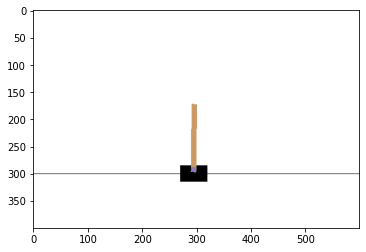

In [ ]:
plt.imshow(im_frame)

In [ ]:
cut = im_frame[(190,284), :, 2][:, np.arange(0,600,1)]/255# ==1

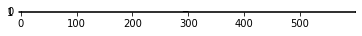

In [ ]:
plt.imshow(cut, cmap='gray')

In [ ]:
cut.shape

(2, 600)

In [ ]:
# final transformation:
[(190,284), :, 2][:, np.arange(0,600,1)].flatten()/255

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cuda


In [ ]:
min_samples_for_training = 500 # Minimum samples in the replay memory to enable the training
# batch_size = 128 # Number of samples to take from the replay memory for each update
batch_size = 50 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0, device = device):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(1)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN().to(device)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN().to(device)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    # optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    optimizer= torch.optim.Adam(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # Reset the environment and get the initial state
        _ = env.reset()
        screen = env.render(mode='rgb_array')
        # state = state.flatten()/255
        screen = screen[(190,284), :, 2][:, np.arange(0,600,1)].flatten()/255
        next_screen = screen
        state = next_screen - screen
        
        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False
        # score_log = []

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau, device = device)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau, device = device)
            
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            envstate, reward, done, info = env.step(action)
            reward = reward - 50 * np.abs(envstate[0]) - 10 * np.abs(envstate[2]) 
            
            next_screen = env.render(mode='rgb_array')
            next_screen = next_screen[(190,284), :, 2][:, np.arange(0,600,1)].flatten()/255
            next_state = next_screen - screen

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > min_samples_for_training: 
                # print('Updating policy network')
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size, device = device)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            state = next_state
            screen = next_screen
        
        score_log.append(score)

        # Print the final score
        print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            # print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    
    max_score = np.max(score_log)
    print(f'Max score: {max_score}')

            # # Early stopping
            # if avg_score == 500:
            #     print(f'\nGame solved after {episode_num + 1} training episodes')
            #     break

            # if episode_num == iter-1 and avg_score < 500:
            #     print(f'\nGame NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    env.close()
    # return test_score_log, episode_num+1
    return score_log, max_score, episode_num+1, policy_net # if we want to further test, we need also the policy_net

In [ ]:
results = []
max_scores = []
pbar = tqdm(total = 16, desc = 'Optimization')
for rate in [0.999, 0.994]:
  for initial_value in [1]:
    # for period in [0, 100]:
      for tnus in [10, 2]: # target_net_update_steps
        for lr in [1e-3, 1e-4]: # 1e-2

          print(f'rate: {rate}, initial_value: {initial_value}, target_net_update_steps: {tnus}, lr: {lr}')
          # key = f'rate:{rate}, init_v:{initial_value}, period: {period}, tnup: {tnus}, lr: {lr}'
          key = f'b:{rate}, t0:{initial_value}, ts:{tnus}, lr:{lr}'

          score_log, max_score, ep_num, _ = main(iter=1000, gamma=0.999, replay_memory_capacity=10000, lr=lr, target_net_update_steps=tnus, 
                                   bad_state_penalty=5, penalization='both', exp_policy='epsilon-greedy', 
                                   initial_value=initial_value, rate=rate, period=0)
          results.append((key, ep_num, score_log))
          max_scores.append((key,max_score))
          print()
          pbar.update(1)
print(max_scores)

rate: 0.999, initial_value: 1, target_net_update_steps: 10, lr: 0.001


EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.999
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.998001
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.997002999
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.996005996001
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.995009990004999
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.994014980014994
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.993020965034979
EPISODE: 9 - FINAL SCORE: 10 - Temperature: 0.992027944069944
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.991035916125874
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9900448802097482
EPISODE: 12 - FINAL SCORE: 8 - Temperature: 0.9890548353295384
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9880657804942089
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 0.9870777147137147
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.986090636999001
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 0.985104546362002
EPISODE: 17 - FINAL SCORE: 9 - Temperature: 0.98

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.999
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.998001
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.997002999
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.996005996001
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.995009990004999
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.994014980014994
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.993020965034979
EPISODE: 9 - FINAL SCORE: 10 - Temperature: 0.992027944069944
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.991035916125874
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9900448802097482
EPISODE: 12 - FINAL SCORE: 8 - Temperature: 0.9890548353295384
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9880657804942089
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 0.9870777147137147
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.986090636999001
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 0.985104546362002
EPISODE: 17 - FINAL SCORE: 9 - Temperature: 0.98

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.999
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.998001
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.997002999
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.996005996001
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.995009990004999
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.994014980014994
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.993020965034979
EPISODE: 9 - FINAL SCORE: 10 - Temperature: 0.992027944069944
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.991035916125874
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9900448802097482
EPISODE: 12 - FINAL SCORE: 8 - Temperature: 0.9890548353295384
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9880657804942089
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 0.9870777147137147
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.986090636999001
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 0.985104546362002
EPISODE: 17 - FINAL SCORE: 9 - Temperature: 0.98

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.999
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.998001
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.997002999
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.996005996001
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.995009990004999
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.994014980014994
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.993020965034979
EPISODE: 9 - FINAL SCORE: 10 - Temperature: 0.992027944069944
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.991035916125874
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9900448802097482
EPISODE: 12 - FINAL SCORE: 8 - Temperature: 0.9890548353295384
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9880657804942089
EPISODE: 14 - FINAL SCORE: 10 - Temperature: 0.9870777147137147
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.986090636999001
EPISODE: 16 - FINAL SCORE: 10 - Temperature: 0.985104546362002
EPISODE: 17 - FINAL SCORE: 9 - Temperature: 0.98

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 10 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 15 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 12 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 9 - Temperature

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 10 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 15 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 12 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 9 - Temperature

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 10 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 15 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 12 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 9 - Temperature

EPISODE: 1 - FINAL SCORE: 9 - Temperature: 1.0
EPISODE: 2 - FINAL SCORE: 10 - Temperature: 0.994
EPISODE: 3 - FINAL SCORE: 10 - Temperature: 0.988036
EPISODE: 4 - FINAL SCORE: 8 - Temperature: 0.982107784
EPISODE: 5 - FINAL SCORE: 10 - Temperature: 0.976215137296
EPISODE: 6 - FINAL SCORE: 9 - Temperature: 0.970357846472224
EPISODE: 7 - FINAL SCORE: 9 - Temperature: 0.9645356993933907
EPISODE: 8 - FINAL SCORE: 10 - Temperature: 0.9587484851970303
EPISODE: 9 - FINAL SCORE: 12 - Temperature: 0.9529959942858481
EPISODE: 10 - FINAL SCORE: 9 - Temperature: 0.947278018320133
EPISODE: 11 - FINAL SCORE: 11 - Temperature: 0.9415943502102122
EPISODE: 12 - FINAL SCORE: 10 - Temperature: 0.9359447841089509
EPISODE: 13 - FINAL SCORE: 11 - Temperature: 0.9303291154042972
EPISODE: 14 - FINAL SCORE: 15 - Temperature: 0.9247471407118714
EPISODE: 15 - FINAL SCORE: 8 - Temperature: 0.9191986578676001
EPISODE: 16 - FINAL SCORE: 12 - Temperature: 0.9136834659203946
EPISODE: 17 - FINAL SCORE: 9 - Temperature

Best score: 103

# Manual feature extraction

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # We need to distinguish between final and non-final states!
    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) 
    # NB: we have previously set the next state to None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]
    # future rewards will be zero for final states

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma) # these are our labels
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)
    # we are optimizing the best possible thing that we can do given our current knowledge, 
    # agaist the direct output of the network (the current policy)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2) # if the sum of the gradinets is larger than 2, we rescale them
    # This prevents the weigths to update too fast
    optimizer.step()

In [ ]:
def manual_feature_extraction(frame, frame_past):

    # static features for the current frame
    top = np.argmin(frame[180,:,2])
    bottom = np.argmin(frame[280,:,2])
    delta = top - bottom

    # static features for the past frame
    top_past = np.argmin(frame_past[180,:,2])
    bottom_past = np.argmin(frame_past[280,:,2])
    delta_past = top_past - bottom_past

    # speed features
    speed = bottom - bottom_past
    speed_delta = delta - delta_past

    return (bottom - 290)/60, speed/2, delta/50, speed_delta/3

In [ ]:
# min_samples_for_training = 1000 # Minimum samples in the replay memory to enable the training
batch_size = 128 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0, msft=1000, w_pos=1, w_angle=10):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(1)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN(state_space_dim, action_space_dim)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    test_score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # ----------------
        # Reset the environment and get the initial state
        state = env.reset()
        frame_past = env.render(mode='rgb_array')
        frame = env.render(mode='rgb_array')
        state = manual_feature_extraction(frame, frame_past)
        # ----------------

        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)
            
            # ----------------
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)
            next_frame = env.render(mode='rgb_array')
            next_state = manual_feature_extraction(next_frame, frame)
            # ----------------

            if penalization == 'position':
                # We apply a (linear) penalty when the cart is far from center
                pos_weight = 1
                reward = reward - pos_weight * np.abs(state[0]) 
            
            elif penalization == 'angle':
                # We apply a (linear) penalty when the cart is far from center
                pos_weight = 10
                reward = reward - pos_weight * np.abs(state[2])

            elif penalization == 'both':
                # We apply a (linear) penalty when the cart is far from center
                reward = reward - w_pos * np.abs(state[0]) - w_angle * np.abs(state[2]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > msft: 
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            # ----------------
            state = next_state
            frame = next_frame
            # ----------------
        
        # Print the final score
        # print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            # print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Test the current network for 5 episodes with temperature = 0
        if (episode_num + 1) % 10 == 0:
            # print('Test (temperature = 0)...')
            score_log = []
            # Let's try for a total of 5 episodes
            for num_episode in range(5): 
                # ----------------
                # Reset the environment and get the initial state
                state = env.reset()
                frame_past = env.render(mode='rgb_array')
                frame = env.render(mode='rgb_array')
                state = manual_feature_extraction(frame, frame_past)
                # ----------------
                # Reset the score. The final score will be the total amount of steps before the pole falls
                score = 0
                done = False
                # Go on until the pole falls off or the score reach 490
                while not done:
                    # Choose the best action (temperature 0)
                    action, q_values = choose_action_softmax(policy_net, state, temperature=0)
                    # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                    # ----------------
                    next_state, reward, done, info = env.step(action)
                    next_frame = env.render(mode='rgb_array')
                    next_state = manual_feature_extraction(next_frame, frame)
                    # ----------------
                    # Visually render the environment
                    # env.render()
                    # Here it makes no sense to change the reward
                    # Update the final score (+1 for each step)
                    score += 1 # or +=1
                    # ----------------
                    # Set the current state for the next iteration
                    state = next_state
                    frame = next_frame
                    # ----------------
                    # Check if the episode ended (the pole fell down)
                # Print the final score
                # print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}")
                score_log.append(score)
            avg_score = np.mean(score_log)
            # print(f'Average test score (over 5 runs) after {episode_num + 1} training episodes: {avg_score:.1f}')
            test_score_log.append(avg_score)
            # Early stopping
            if avg_score == 500:
                print(f'Game solved after {episode_num + 1} training episodes')
                break

            if episode_num == iter-1 and avg_score < 500:
                print(f'Game NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    env.close()
    # return test_score_log, episode_num+1
    return test_score_log, episode_num+1, policy_net # if we want to further test, we need also the policy_net

### First search

In [ ]:
results = []
pbar = tqdm(total = 64, desc = 'Optimization')

for rate in [0.98, 0.99]:
  for gamma in [0.97, 0.99]:
    for w_pos in [1, 10]:
      for w_angle in [10, 100]:
        for tnus in [1, 5]: # target_net_update_steps
          for lr in [1e-1, 1e-2]: 

            print(f'rate: {rate}, gamma:{gamma}, w_p:{w_pos}, w_a:{w_angle}, target_net_update_steps: {tnus}, lr: {lr}')
            key = f'b:{rate}, gamma:{gamma}, w_p:{w_pos}, w_a:{w_angle}, lr:{lr}'

            score_log, ep_num, _ = main(iter=1000, gamma=gamma, replay_memory_capacity=10000, lr=lr, target_net_update_steps=tnus, 
                                    bad_state_penalty=0, penalization='both', exp_policy='epsilon-greedy', 
                                    initial_value=1, rate=rate, period=0, msft=500, w_pos = w_pos, w_angle = w_angle)
            results.append((key, ep_num, score_log))
            print()
            pbar.update(1)

rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 255.0


rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 23.6


rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 209.6


rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 28.8


rate: 0.98, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 56.8


rate: 0.98, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 54.6


rate: 0.98, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 48.8


rate: 0.98, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 22.4


rate: 0.98, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 92.0


rate: 0.98, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 50.2


rate: 0.98, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 112.4


rate: 0.98, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 180.2


rate: 0.98, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 63.0


rate: 0.98, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 54.6


rate: 0.98, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 30.2


rate: 0.98, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 15.0


rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 69.6


rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 66.6


rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 189.0


rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 36.6


rate: 0.98, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 143.0


rate: 0.98, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 10.2


rate: 0.98, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 23.6


rate: 0.98, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 22.4


rate: 0.98, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 119.4


rate: 0.98, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 40.6


rate: 0.98, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 81.6


rate: 0.98, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 60.2


rate: 0.98, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 273.4


rate: 0.98, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 11.2


rate: 0.98, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 18.2


rate: 0.98, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 34.8


rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 185.4


rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 122.4


rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 120.0


rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 128.8


rate: 0.99, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 168.4


rate: 0.99, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 75.8


rate: 0.99, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 166.6


rate: 0.99, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 158.8


rate: 0.99, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 69.0


rate: 0.99, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 109.2


rate: 0.99, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 97.4


rate: 0.99, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 109.2


rate: 0.99, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 134.2


rate: 0.99, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 11.8


rate: 0.99, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 72.0


rate: 0.99, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.01


Game solved after 230 training episodes

rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 125.0


rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 160.4


rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 319.0


rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 139.0


rate: 0.99, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 76.8


rate: 0.99, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 11.8


rate: 0.99, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 114.6


rate: 0.99, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 40.8


rate: 0.99, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 57.6


rate: 0.99, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 61.4


rate: 0.99, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 107.2


rate: 0.99, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 54.6


rate: 0.99, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 83.0


rate: 0.99, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 11.8


rate: 0.99, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 81.2


rate: 0.99, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 185.8




###Additional test

In [ ]:
# rate: 0.99, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.01
score_log, ep_num, policy_net = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=0.01, target_net_update_steps=5, 
                                    bad_state_penalty=0, penalization='both', exp_policy='epsilon-greedy', 
                                    initial_value=1, rate=0.99, period=0, msft=500, w_pos = 10, w_angle = 100)

Game solved after 230 training episodes


In [ ]:
# TEST WITH VIDEO! IT DOES NOT NEED ADDITIONAL OUTPUT FROM THE TRAINING LOOP
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_log = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(5): 
    # Reset the environment and get the initial state
    state = env.reset()
    frame_past = env.render(mode='rgb_array')
    frame = env.render(mode='rgb_array')
    state = manual_feature_extraction(frame, frame_past)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        next_frame = env.render(mode='rgb_array')
        next_state = manual_feature_extraction(next_frame, frame)
        # Visually render the environment
        env.render()
        # Here it makes no sense to change the reward
        # Update the final score (+1 for each step)
        score += 1 # or +=1
        # Set the current state for the next iteration
        state = next_state
        frame = next_frame
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    score_log.append(score)
avg_score = np.mean(score_log)
print(f'Average test score (over 5 runs): {avg_score:.1f}')
# test_score_log.append(avg_score)
env.close()

TEST EPISODE 1 - FINAL SCORE: 500
TEST EPISODE 2 - FINAL SCORE: 500
TEST EPISODE 3 - FINAL SCORE: 500
TEST EPISODE 4 - FINAL SCORE: 500
TEST EPISODE 5 - FINAL SCORE: 500
Average test score (over 5 runs): 500.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.0.62.video000000.mp4



SHOWING VIDEO video/openaigym.video.0.62.video000001.mp4



SHOWING VIDEO video/openaigym.video.0.62.video000002.mp4



SHOWING VIDEO video/openaigym.video.0.62.video000003.mp4



SHOWING VIDEO video/openaigym.video.0.62.video000004.mp4


# Manual feature extraction - different formulation

In [ ]:
def manual_feature_extraction(frame, frame_past):

    # static features for the current frame
    top = np.argmin(frame[180,:,2])
    bottom = np.argmin(frame[280,:,2])
    delta = top - bottom

    # static features for the past frame
    top_past = np.argmin(frame_past[180,:,2])
    bottom_past = np.argmin(frame_past[280,:,2])
    delta_past = top_past - bottom_past

    # speed features
    speed = bottom - bottom_past
    speed_delta = delta - delta_past

    return (bottom - 295)/100, speed/2, delta/100, speed_delta/2

In [ ]:
env = gym.make('CartPole-v1') 
env.seed(0)
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode
a = env.reset()
frames = []
im_frame = env.render(mode='rgb_array')
frames.append(im_frame)
for i in range(10):
    next_state, reward, done, info = env.step(1)
    im_frame1 = env.render(mode='rgb_array')
    print(next_state)
    print(manual_feature_extraction(im_frame1, im_frame))

    im_frame = im_frame1
    # print(np.argmin(im_frame1[180,:,2]))
    # print(np.argmin(im_frame1[280,:,2]))
    # print()
    frames.append(im_frame)
env.close()

[-0.04363321  0.24146826  0.01284913 -0.30946528]
(-0.05, 0.0, 0.01, 0.0)
[-0.03880385  0.43640481  0.00665982 -0.59806842]
(-0.05, 0.0, 0.01, 0.0)
[-0.03007575  0.63143294 -0.00530154 -0.88864615]
(-0.04, 0.5, 0.0, -0.5)
[-0.01744709  0.82662643 -0.02307447 -1.18299093]
(-0.02, 1.0, -0.03, -1.5)
[-9.14563642e-04  1.02204008e+00 -4.67342864e-02 -1.48281666e+00]
(-0.01, 0.5, -0.04, -0.5)
[ 0.01952624  1.21769983 -0.07639062 -1.78972072]
(0.02, 1.5, -0.08, -2.0)
[ 0.04388023  1.41359111 -0.11218503 -2.10513771]
(0.04, 1.0, -0.11, -1.5)
[ 0.07215206  1.60964469 -0.15428779 -2.43028271]
(0.07, 1.5, -0.15, -2.0)
[ 0.10434495  1.80572006 -0.20289344 -2.76608293]
(0.1, 1.5, -0.2, -2.5)
[ 0.14045935  2.00158653 -0.2582151  -3.11309836]
(0.14, 2.0, -0.26, -3.0)


In [ ]:
[ 0.10410878  1.778629   -0.22511162 -2.78708585]
/60             /2       /50          /2

In [ ]:
manual_feature_extraction(im_frame, im_frame1)

(290, 0, 1, 0)

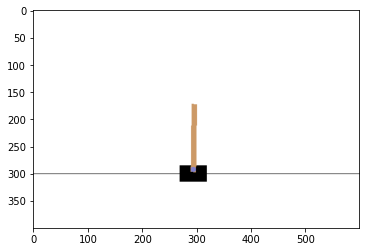

In [ ]:
plt.imshow(im_frame0)

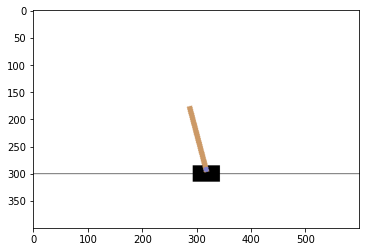

In [ ]:
plt.imshow(im_frame1)

In [ ]:
# min_samples_for_training = 1000 # Minimum samples in the replay memory to enable the training
batch_size = 128 # Number of samples to take from the replay memory for each update

def main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=1e-2, target_net_update_steps=10, 
         bad_state_penalty=0, penalization='position', exp_policy='softmax', initial_value=1, rate=0.99, period=0, msft=1000, w_pos=1, w_angle=10):

    ep = exploration_profile(1000, initial_value=initial_value, rate=rate, period=period)

    # --- Set random seeds ---
    torch.manual_seed(1)
    np.random.seed(0)
    random.seed(0)

    # --- Initialize the replay memory ---
    replay_mem = ReplayMemory(replay_memory_capacity)    

    # --- Initialize the policy network ---
    policy_net = DQN(state_space_dim, action_space_dim)

    # --- Initialize the target network with the same weights of the policy network ---
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) 
    # This will copy the weights of the policy network to the target network:
    # needed because Pytorch initialize them differently

    # --- Initialize the optimizer ---
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) 
    # The optimizer will update ONLY the parameters of the policy network
    # NB: in RL keeping the previous directions of the gradient may not be beneficial!
    # Stability is the main problem of RL...

    # --- Initialize the loss function (Huber loss) ---
    loss_fn = nn.SmoothL1Loss()

    # --- Initialize the Gym environment ---
    env = gym.make('CartPole-v1') 
    env.seed(0) # Set a random seed for the environment (reproducible results)

    ## This is for creating the output video in Colab, not required outside Colab
    # env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

    test_score_log = []

    for episode_num, tau in enumerate(tqdm(ep[:iter])):

        # ----------------
        # Reset the environment and get the initial state
        state = env.reset()
        frame_past = env.render(mode='rgb_array')
        frame = env.render(mode='rgb_array')
        state = manual_feature_extraction(frame, frame_past)
        # ----------------

        # Reset the score. The final score will be the total amount of steps before the pole falls
        score = 0
        done = False

        # Go on until the pole falls off
        while not done:

            # --- Scegliamo un'azione, facciamo uno step, modifichiamo il reward e aggiungiamo la 4-tupla alla replay memory ---
            # Choose the action following the policy
            if exp_policy == 'softmax':
                action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
            elif exp_policy == 'epsilon-greedy':
                action, q_values = choose_action_epsilon_greedy(policy_net, state, epsilon=tau)
            
            # ----------------
            # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
            next_state, reward, done, info = env.step(action)
            next_frame = env.render(mode='rgb_array')
            next_state = manual_feature_extraction(next_frame, frame)
            # ----------------

            if penalization == 'position':
                # We apply a (linear) penalty when the cart is far from center
                pos_weight = 1
                reward = reward - pos_weight * np.abs(state[0]) 
            
            elif penalization == 'angle':
                # We apply a (linear) penalty when the cart is far from center
                pos_weight = 10
                reward = reward - pos_weight * np.abs(state[2])

            elif penalization == 'both':
                # We apply a (linear) penalty when the cart is far from center
                reward = reward - w_pos * np.abs(state[0]) - w_angle * np.abs(state[2]) 

            # Update the final score (+1 for each step)
            score += 1

            # Apply penalty for bad state
            if done: # if the pole has fallen down 
                reward -= bad_state_penalty
                next_state = None

            # Update the replay memory
            replay_mem.push(state, action, next_state, reward)

            # --- quando abbiamo abbastanza dati, aggiorniamo la network ---
            # Update the network
            if len(replay_mem) > msft: 
                # we enable the training only if we have enough samples in the replay memory, 
                # otherwise the training will use the same samples too often
                update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

            # Visually render the environment (disable to speed up the training)
            # env.render()

            # Set the current state for the next iteration
            # ----------------
            state = next_state
            frame = next_frame
            # ----------------
        
        # Print the final score
        # print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score

        # Update the target network every target_net_update_steps = 10 episodes
        if (episode_num + 1) % target_net_update_steps == 0:
            # print('Updating target network...')
            target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

        # Test the current network for 5 episodes with temperature = 0
        if (episode_num + 1) % 10 == 0:
            # print('Test (temperature = 0)...')
            score_log = []
            # Let's try for a total of 5 episodes
            for num_episode in range(5): 
                # ----------------
                # Reset the environment and get the initial state
                state = env.reset()
                frame_past = env.render(mode='rgb_array')
                frame = env.render(mode='rgb_array')
                state = manual_feature_extraction(frame, frame_past)
                # ----------------
                # Reset the score. The final score will be the total amount of steps before the pole falls
                score = 0
                done = False
                # Go on until the pole falls off or the score reach 490
                while not done:
                    # Choose the best action (temperature 0)
                    action, q_values = choose_action_softmax(policy_net, state, temperature=0)
                    # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
                    # ----------------
                    next_state, reward, done, info = env.step(action)
                    next_frame = env.render(mode='rgb_array')
                    next_state = manual_feature_extraction(next_frame, frame)
                    # ----------------
                    # Visually render the environment
                    # env.render()
                    # Here it makes no sense to change the reward
                    # Update the final score (+1 for each step)
                    score += 1 # or +=1
                    # ----------------
                    # Set the current state for the next iteration
                    state = next_state
                    frame = next_frame
                    # ----------------
                    # Check if the episode ended (the pole fell down)
                # Print the final score
                # print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}")
                score_log.append(score)
            avg_score = np.max(score_log)
            # print(f'Average test score (over 5 runs) after {episode_num + 1} training episodes: {avg_score:.1f}')
            test_score_log.append(avg_score)
            # Early stopping
            if avg_score == 500:
                print(f'Game solved after {episode_num + 1} training episodes')
                break

            if episode_num == iter-1 and avg_score < 500:
                print(f'Game NOT solved after {episode_num + 1} training episodes. Best score: {np.max(test_score_log)}')
    
    env.close()
    # return test_score_log, episode_num+1
    return test_score_log, episode_num+1, policy_net # if we want to further test, we need also the policy_net

### Second search

In [ ]:
results = []
pbar = tqdm(total = 64, desc = 'Optimization')

for rate in [0.98, 0.99]:
  for gamma in [0.97, 0.99]:
    for w_pos in [1, 10]:
      for w_angle in [10, 100]:
        for tnus in [1, 5]: # target_net_update_steps
          for lr in [1e-1, 1e-2]: 

            print(f'rate: {rate}, gamma:{gamma}, w_p:{w_pos}, w_a:{w_angle}, target_net_update_steps: {tnus}, lr: {lr}')
            key = f'b:{rate}, gamma:{gamma}, w_p:{w_pos}, w_a:{w_angle}, lr:{lr}'

            score_log, ep_num, _ = main(iter=1000, gamma=gamma, replay_memory_capacity=10000, lr=lr, target_net_update_steps=tnus, 
                                    bad_state_penalty=0, penalization='both', exp_policy='epsilon-greedy', 
                                    initial_value=1, rate=rate, period=0, msft=500, w_pos = w_pos, w_angle = w_angle)
            results.append((key, ep_num, score_log))
            print()
            pbar.update(1)

rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game solved after 990 training episodes

rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 170


rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game solved after 730 training episodes

rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 269


rate: 0.98, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 106


rate: 0.98, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 159


rate: 0.98, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 145


rate: 0.98, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 92


rate: 0.98, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 260


rate: 0.98, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 43


rate: 0.98, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 143


rate: 0.98, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 20


rate: 0.98, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 119


rate: 0.98, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 201


rate: 0.98, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 70


rate: 0.98, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 123


rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game solved after 390 training episodes

rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game solved after 620 training episodes

rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game solved after 380 training episodes

rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game solved after 850 training episodes

rate: 0.98, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 123


rate: 0.98, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 51


rate: 0.98, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 37


rate: 0.98, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 202


rate: 0.98, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 215


rate: 0.98, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 42


rate: 0.98, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 166


rate: 0.98, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 93


rate: 0.98, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 214


rate: 0.98, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 38


rate: 0.98, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 19


rate: 0.98, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 42


rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game solved after 160 training episodes

rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game solved after 390 training episodes

rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game solved after 370 training episodes

rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game solved after 830 training episodes

rate: 0.99, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 496


rate: 0.99, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 127


rate: 0.99, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 405


rate: 0.99, gamma:0.97, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 346


rate: 0.99, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 221


rate: 0.99, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 183


rate: 0.99, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 196


rate: 0.99, gamma:0.97, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 42


rate: 0.99, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 185


rate: 0.99, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 137


rate: 0.99, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 263


rate: 0.99, gamma:0.97, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 111


rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game solved after 350 training episodes

rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game solved after 840 training episodes

rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game solved after 360 training episodes

rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game solved after 730 training episodes

rate: 0.99, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 240


rate: 0.99, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 58


rate: 0.99, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 174


rate: 0.99, gamma:0.99, w_p:1, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 72


rate: 0.99, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 248


rate: 0.99, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 77


rate: 0.99, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 214


rate: 0.99, gamma:0.99, w_p:10, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 37


rate: 0.99, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 73


rate: 0.99, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 43


rate: 0.99, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.1


Game NOT solved after 1000 training episodes. Best score: 117


rate: 0.99, gamma:0.99, w_p:10, w_a:100, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 173




### Third search: only the best reward strategy

In [ ]:
results = []
pbar = tqdm(total = 16, desc = 'Optimization')

for rate in [0.98, 0.99]:
  for gamma in [0.97, 0.99]:
    for w_pos in [1]:
      for w_angle in [10]:
        for tnus in [1, 5]: # target_net_update_steps
          for lr in [1e-1, 1e-2]: 

            print(f'rate: {rate}, gamma:{gamma}, w_p:{w_pos}, w_a:{w_angle}, target_net_update_steps: {tnus}, lr: {lr}')
            key = f'b:{rate}, gamma:{gamma}, w_p:{w_pos}, w_a:{w_angle}, lr:{lr}'

            score_log, ep_num, _ = main(iter=1000, gamma=gamma, replay_memory_capacity=10000, lr=lr, target_net_update_steps=tnus, 
                                    bad_state_penalty=0, penalization='both', exp_policy='epsilon-greedy', 
                                    initial_value=1, rate=rate, period=0, msft=500, w_pos = w_pos, w_angle = w_angle)
            results.append((key, ep_num, score_log))
            print()
            pbar.update(1)

rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game solved after 990 training episodes

rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 170


rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game solved after 730 training episodes

rate: 0.98, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game NOT solved after 1000 training episodes. Best score: 269


rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game solved after 390 training episodes

rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game solved after 620 training episodes

rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game solved after 380 training episodes

rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game solved after 850 training episodes

rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game solved after 160 training episodes

rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game solved after 390 training episodes

rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game solved after 370 training episodes

rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game solved after 830 training episodes

rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1


Game solved after 350 training episodes

rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01


Game solved after 840 training episodes

rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1


Game solved after 360 training episodes

rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.01


Game solved after 730 training episodes



### Additional tests

In [ ]:
# rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1
# rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1
# rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1

score_log, ep_num, policy_net = main(iter=1000, gamma=0.99, replay_memory_capacity=10000, lr=0.1, target_net_update_steps=5, 
                                   bad_state_penalty=0, penalization='both', exp_policy='epsilon-greedy', 
                                   initial_value=1, rate=0.99, period=0, msft=500, w_pos=1, w_angle=10)

Game solved after 360 training episodes


In [ ]:
# TEST WITH VIDEO! IT DOES NOT NEED ADDITIONAL OUTPUT FROM THE TRAINING LOOP
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_log = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(5): 
    # Reset the environment and get the initial state
    state = env.reset()
    frame_past = env.render(mode='rgb_array')
    frame = env.render(mode='rgb_array')
    state = manual_feature_extraction(frame, frame_past)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        next_frame = env.render(mode='rgb_array')
        next_state = manual_feature_extraction(next_frame, frame)
        # Visually render the environment
        env.render()
        # Here it makes no sense to change the reward
        # Update the final score (+1 for each step)
        score += 1 # or +=1
        # Set the current state for the next iteration
        state = next_state
        frame = next_frame
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    score_log.append(score)
avg_score = np.mean(score_log)
print(f'Average test score (over 5 runs): {avg_score:.1f}')
# test_score_log.append(avg_score)
env.close()

TEST EPISODE 1 - FINAL SCORE: 500
TEST EPISODE 2 - FINAL SCORE: 213
TEST EPISODE 3 - FINAL SCORE: 500
TEST EPISODE 4 - FINAL SCORE: 500
TEST EPISODE 5 - FINAL SCORE: 500
Average test score (over 5 runs): 442.6


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.1.62.video000000.mp4



SHOWING VIDEO video/openaigym.video.1.62.video000001.mp4



SHOWING VIDEO video/openaigym.video.1.62.video000002.mp4



SHOWING VIDEO video/openaigym.video.1.62.video000003.mp4



SHOWING VIDEO video/openaigym.video.1.62.video000004.mp4


### Additional tests

In [ ]:
# rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1
# rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1
# rate: 0.99, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1
# rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.1
# rate: 0.98, gamma:0.99, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1
# rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 5, lr: 0.1
# rate: 0.99, gamma:0.97, w_p:1, w_a:10, target_net_update_steps: 1, lr: 0.01
score_log, ep_num, policy_net = main(iter=1000, gamma=0.97, replay_memory_capacity=10000, lr=0.01, target_net_update_steps=1, 
                                   bad_state_penalty=0, penalization='both', exp_policy='epsilon-greedy', 
                                   initial_value=1, rate=0.99, period=0, msft=500, w_pos=1, w_angle=10)

Game solved after 390 training episodes


In [ ]:
# TEST WITH VIDEO! IT DOES NOT NEED ADDITIONAL OUTPUT FROM THE TRAINING LOOP
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)
score_log = []

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    frame_past = env.render(mode='rgb_array')
    frame = env.render(mode='rgb_array')
    state = manual_feature_extraction(frame, frame_past)
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
        # Choose the best action (temperature 0)
        action, q_values = choose_action_softmax(policy_net, state, temperature=0)
        # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
        next_state, reward, done, info = env.step(action)
        next_frame = env.render(mode='rgb_array')
        next_state = manual_feature_extraction(next_frame, frame)
        # Visually render the environment
        env.render()
        # Here it makes no sense to change the reward
        # Update the final score (+1 for each step)
        score += 1 # or +=1
        # Set the current state for the next iteration
        state = next_state
        frame = next_frame
        # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"TEST EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
    score_log.append(score)
avg_score = np.mean(score_log)
print(f'Average test score (over 5 runs): {avg_score:.1f}')
# test_score_log.append(avg_score)
env.close()

TEST EPISODE 1 - FINAL SCORE: 500
TEST EPISODE 2 - FINAL SCORE: 193
TEST EPISODE 3 - FINAL SCORE: 500
TEST EPISODE 4 - FINAL SCORE: 500
TEST EPISODE 5 - FINAL SCORE: 500
TEST EPISODE 6 - FINAL SCORE: 500
TEST EPISODE 7 - FINAL SCORE: 500
TEST EPISODE 8 - FINAL SCORE: 500
TEST EPISODE 9 - FINAL SCORE: 500
TEST EPISODE 10 - FINAL SCORE: 500
Average test score (over 5 runs): 469.3


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.9.62.video000000.mp4



SHOWING VIDEO video/openaigym.video.9.62.video000001.mp4



SHOWING VIDEO video/openaigym.video.9.62.video000002.mp4



SHOWING VIDEO video/openaigym.video.9.62.video000003.mp4



SHOWING VIDEO video/openaigym.video.9.62.video000004.mp4



SHOWING VIDEO video/openaigym.video.9.62.video000005.mp4



SHOWING VIDEO video/openaigym.video.9.62.video000006.mp4



SHOWING VIDEO video/openaigym.video.9.62.video000007.mp4



SHOWING VIDEO video/openaigym.video.9.62.video000008.mp4



SHOWING VIDEO video/openaigym.video.9.62.video000009.mp4
